<a href="https://colab.research.google.com/github/Sawnann/colab-test/blob/main/%E3%80%8Ca_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import itertools

In [ ]:
# 忽略警告
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving KHQb3Ny62YxXnCEon4mm43-1200-80.jpg to KHQb3Ny62YxXnCEon4mm43-1200-80 (1).jpg


In [ ]:
# 讀取數據
df=pd.read_csv("viscosity.csv")
deg=df[['Month','deg']]
deg=pd.DataFrame(deg)
deg['Month']=pd.to_datetime(deg['Month'])

In [ ]:
df1 = deg.set_index('Month')

In [ ]:
monthly = df1.resample('M').mean()
monthly.head()

,deg
Month,
1960-01-31,0.628
1960-02-29,0.631
1960-03-31,0.634
1960-04-30,0.633
1960-05-31,0.631


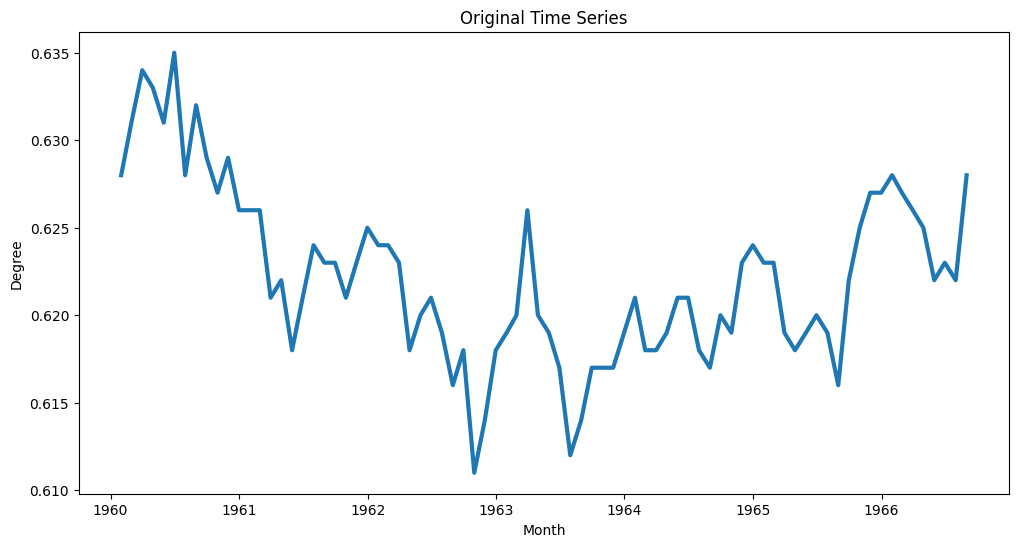

In [ ]:
# 繪製原始時間序列
plt.figure(figsize=(12, 6))
plt.plot(monthly['deg'], linewidth=3)
plt.title("Original Time Series")
plt.xlabel("Month")
plt.ylabel("Degree")
plt.show()

In [ ]:
def check_stationarity(timeseries):
	# Perform the Dickey-Fuller test
	result = adfuller(timeseries, autolag='AIC')
	p_value = result[1]
	print(f'ADF Statistic: {result[0]}')
	print(f'p-value: {p_value}')
	print('Stationary' if p_value < 0.05 else 'Non-Stationary')

In [ ]:
check_stationarity(monthly['deg'])

ADF Statistic: -2.632554698535509
p-value: 0.08645378550790611
Non-Stationary


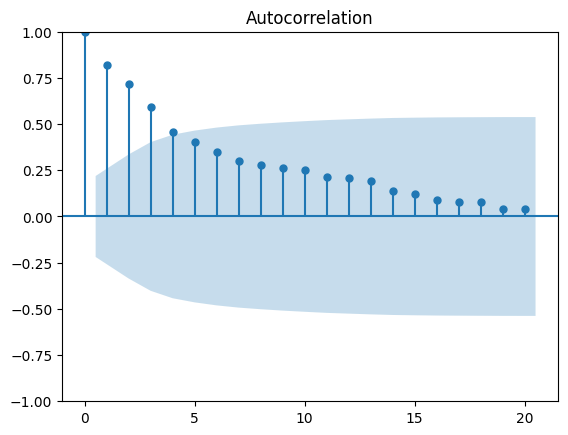

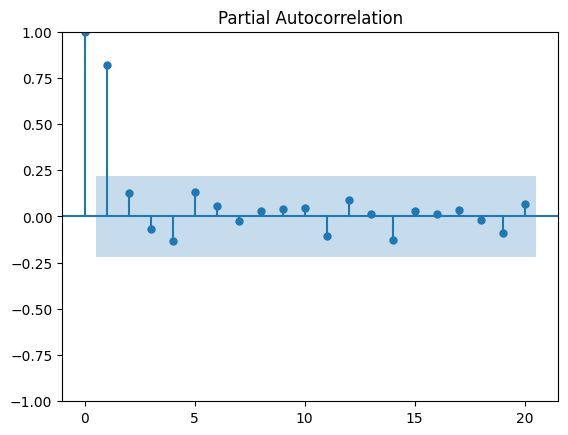

In [ ]:
# Plot ACF and PACF
plot_acf(monthly)
plot_pacf(monthly)
plt.show()

In [ ]:
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12 # Assuming monthly seasonality

In [ ]:
# Fit the SARIMA model
model = SARIMAX(monthly, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

In [ ]:
# Forecast future values
forecast_periods = 30 # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

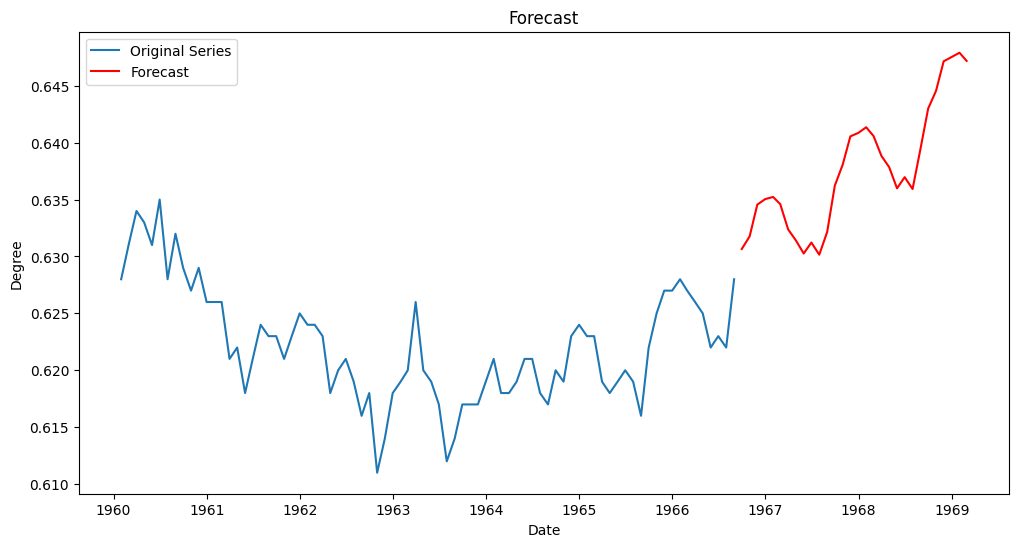

In [ ]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly, label='Original Series')
plt.plot(forecast_mean, label='Forecast', color='red')
#plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecast")
plt.xlabel("Date")
plt.ylabel("Degree")
plt.legend()
plt.show()

In [ ]:
observed = monthly[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
mape = mean_absolute_percentage_error(observed, forecast_mean)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAPE: {mape:.4f}')

MAE: 0.0157
MSE: 0.0003
MAPE: 0.0252


In [ ]:
'''
# Dickey-Fuller 測試
def adfuller_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f"{label} : {value}")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

adfuller_test(df['deg'])

# 差分處理
df['Difference'] = df['deg'] - df['deg'].shift(12)
adfuller_test(df['Difference'].dropna())

# 繪製 ACF 和 PACF 圖
plt.figure(figsize=(10, 6))
plot_acf(df['Difference'].dropna(), lags=32)
plt.title('Autocorrelation Function')
#plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(df['Difference'].dropna(), lags=32)
plt.title('Partial Autocorrelation Function')
#plt.grid(True)
plt.show()

# 分割訓練集和測試集
train_size = int(len(df) * 0.625)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# SARIMA 模型選擇和擬合

# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = sm.tsa.statespace.SARIMAX(train['deg'], order=param, seasonal_order=param_seasonal)
#             results = model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = param_seasonal
#         except Exception as e:
#             continue

# print(f"Best SARIMA{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}")

# 最佳模型擬合
model = sm.tsa.statespace.SARIMAX(df['deg'], order= (1,1,1), seasonal_order=(0,1,1,12))
results = model.fit(disp=False)

# 預測
df['forecast'] = results.predict(start=train_size, end=len(df)-1, dynamic=False)

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['deg'], label='Original Series')
plt.plot(df['Month'][train_size:], df['forecast'][train_size:], label='Forecast', color='red')
plt.legend(fontsize=12, loc='best', shadow=True)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.title('SARIMA Forecast')
#plt.grid(True)
plt.show()

# 計算誤差指標
train_forecast = results.predict(start=0, end=train_size-1)
test_forecast = results.predict(start=train_size, end=len(df)-1)

train_mse = mean_squared_error(train['deg'], train_forecast)
train_mae = mean_absolute_error(train['deg'], train_forecast)
train_mape = mean_absolute_percentage_error(train['deg'], train_forecast)

test_mse = mean_squared_error(test['deg'], test_forecast)
test_mae = mean_absolute_error(test['deg'], test_forecast)
test_mape = mean_absolute_percentage_error(test['deg'], test_forecast)

print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.4f}")'''

'\n# Dickey-Fuller 測試\ndef adfuller_test(series):\n    result = adfuller(series.dropna())\n    labels = [\'ADF Test Statistic\', \'p-value\', \'#Lags Used\', \'Number of Observations Used\']\n    for value, label in zip(result, labels):\n        print(f"{label} : {value}")\n    if result[1] <= 0.05:\n        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")\n    else:\n        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")\n\nadfuller_test(df[\'deg\'])\n\n# 差分處理\ndf[\'Difference\'] = df[\'deg\'] - df[\'deg\'].shift(12)\nadfuller_test(df[\'Difference\'].dropna())\n\n# 繪製 ACF 和 PACF 圖\nplt.figure(figsize=(10, 6))\nplot_acf(df[\'Difference\'].dropna(), lags=32)\nplt.title(\'Autocorrelation Function\')\n#plt.grid(True)\nplt.show()\n\nplt.figure(figsize=(10, 6))\nplot_pacf(df[\'Difference\'].dropna(), lags=32)\nplt.title(\'Partial Autocorrelation Funct